# Consulting Case: Recommending the Best Diamonds for Greg

### Objective:
To provide Greg with recommendations for choosing a diamond for Sarah, based on the best possible balance between price and quality. The project follows an analytical approach involving machine learning methods and step-by-step analysis to identify the most valuable diamonds.

### Key Steps:
1. Data loading and preprocessing:
- Loaded data for ~6000 diamonds from an Excel file.
- Performed basic cleaning and preparation, including converting categorical features (e.g., Cut, Color, Clarity) into numerical format using LabelEncoder.

2. Categorical feature encoding:
- Converted text-based categorical columns into numerical format for model compatibility.

3. Data splitting:
- Split the dataset into training and testing sets using train_test_split (80% train / 20% test).

4. Feature scaling: 
- Applied StandardScaler to normalize feature values and handle differences in scale.

5. Model training:
- Trained a RandomForestRegressor model to predict diamond prices.
- Used GridSearchCV for hyperparameter tuning (e.g., n_estimators=150, max_depth=20) to improve performance.

6. Model evaluation:
- Assessed performance using:
MAE (Mean Absolute Error) — measures how close predictions are to actual prices.
R² Score (Coefficient of Determination) — reflects how well the model explains price variance.
Cross-validation used with GridSearchCV for robustness.

7. Generating predictions and recommendations:
- Used the best model from grid search to predict prices.
- Added predicted prices and calculated a new metric: Price per Carat.
- Applied filters (e.g., budget ≤ $3000, preferred cut) to generate recommendations.
- Identified Top 5 diamonds with the best price-to-carat ratio.

8. Result visualization:
- Created a feature importance plot to show which attributes (e.g., Carat Weight) most influence price.
- Plotted price distribution for all diamonds vs. recommended ones on a single graph.

9. Exporting final results:
- Exported the full dataset with predictions and recommendations to a multi-sheet Excel file: diamond_analysis_report.xlsx, including:
Filtered (Min $3000) — Diamonds filtered by budget.
Top 5 (Min $3000) — Top 5 filtered diamonds.
Filtered (No Min Budget) — Full data without budget filter.
Top 5 (No Min Budget) — Top 5 diamonds from unfiltered list.

Also exported final recommendations as a CSV file: top_5_diamonds.csv.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1: Load the data
raw_data = pd.read_excel('./data.xlsx', sheet_name='Raw Data')

In [3]:
# Step 2: Encode Categorical Variables
categorical_columns = ['Cut', 'Color', 'Clarity', 'Polish', 'Symmetry', 'Report']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    raw_data[col] = le.fit_transform(raw_data[col])
    label_encoders[col] = le

In [4]:
# Step 3: Splitting Data
X = raw_data.drop(columns=['ID', 'Price'])
y = raw_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Step 4: Scaling Features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [6]:
# Step 5: Initialize the Random Forest Regressor
model = RandomForestRegressor(random_state=42)

# Step 6: Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 150],  # Уменьшите количество деревьев
    'max_depth': [10, 20],        # Уменьшите максимальную глубину
    'min_samples_split': [2, 5],   # Уменьшите минимальное количество образцов для разбиения
}

# Инициализация GridSearchCV с использованием 2 ядер вместо всех (n_jobs=2)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=2)
grid_search.fit(X_train_scaled, y_train)

# Вывод лучших параметров и результата
print("Best parameters from GridSearchCV:", grid_search.best_params_)
print("Best score from GridSearchCV:", grid_search.best_score_)

Best parameters from GridSearchCV: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}
Best score from GridSearchCV: -753.7033161482008


In [7]:
# Step 7: Evaluate the Model with the Best Hyperparameters (GridSearchCV)
best_model = grid_search.best_estimator_

# Прогнозирование с лучшей моделью
y_pred = best_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Вывод метрик качества модели
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 666.1801953412789
R² Score: 0.9853740221179613


In [8]:
# Step 8: Add predictions to the dataset
# Добавление предсказанных цен в исходные данные
raw_data['Predicted Price'] = best_model.predict(pd.DataFrame(scaler.transform(X), columns=X.columns))
raw_data['Price per Carat'] = raw_data['Predicted Price'] / raw_data['Carat Weight']

# Step 9: Filter and Recommend Top Diamonds
filtered_data_min_budget = raw_data[
    (raw_data['Price'] <= 3000) &  # Выбираются бриллианты с ценой до $3000
    (raw_data['Carat Weight'] <= 1.0) &  # Выбираются бриллианты с весом до 1 карата
    (raw_data['Cut'].isin([2, 1, 0])) &  # Огранка должна быть "Очень хорошая" (2), "Идеальная" (1) или "Безупречно идеальная" (0)
    (raw_data['Clarity'].isin([0, 1, 2, 3])) &  # Чистота бриллианта должна быть от FL (0) до VS2 (3)
    (raw_data['Color'].isin([0, 1, 2, 3]))  # Цвет бриллианта должен быть от D (0) до G (3)
]
filtered_data_min_budget = filtered_data_min_budget.sort_values(by='Price per Carat', ascending=True)

# Сценарий без минимального бюджета
filtered_data_no_min_budget = raw_data[
    (raw_data['Carat Weight'] <= 1.0) &  # Выбираются бриллианты с весом до 1 карата
    (raw_data['Cut'].isin([2, 1, 0])) &  # Огранка должна быть "Очень хорошая" (2), "Идеальная" (1) или "Безупречно идеальная" (0)
    (raw_data['Clarity'].isin([0, 1, 2, 3])) &  # Чистота бриллианта должна быть от FL (0) до VS2 (3)
    (raw_data['Color'].isin([0, 1, 2, 3]))  # Цвет бриллианта должен быть от D (0) до G (3)
]
filtered_data_no_min_budget = filtered_data_no_min_budget.sort_values(by='Price per Carat', ascending=True)

# Сортировка по цене на карат и выбор топ-5
top_5_diamonds = filtered_data_min_budget.sort_values(by='Price per Carat', ascending=True).head(5)

print("Top 5 Recommended Diamonds:")
pd.set_option('display.width', 1000) 
pd.set_option('display.max_columns', None)
print(top_5_diamonds)

# Сохраняем топ-5 бриллиантов в CSV файл с нужными колонками
top_5_diamonds[['ID', 'Carat Weight', 'Cut', 'Color', 'Clarity', 'Price', 'Price per Carat']].to_csv(
    'top_5_diamonds.csv', index=False, sep=';', encoding='utf-8-sig'
)

Top 5 Recommended Diamonds:
        ID  Carat Weight  Cut  Color  Clarity  Polish  Symmetry  Report  Price  Predicted Price  Price per Carat
4313  4314          0.80    1      3        2       3         1       1   2662      2772.566540      3465.708175
3858  3859          0.80    1      3        2       3         1       1   2810      2772.566540      3465.708175
904    905          0.85    1      3        2       3         3       1   2905      2959.059365      3481.246312
2590  2591          0.85    1      3        2       3         3       1   2945      2959.059365      3481.246312
3635  3636          0.84    1      3        2       3         1       1   2872      2926.206667      3483.579365


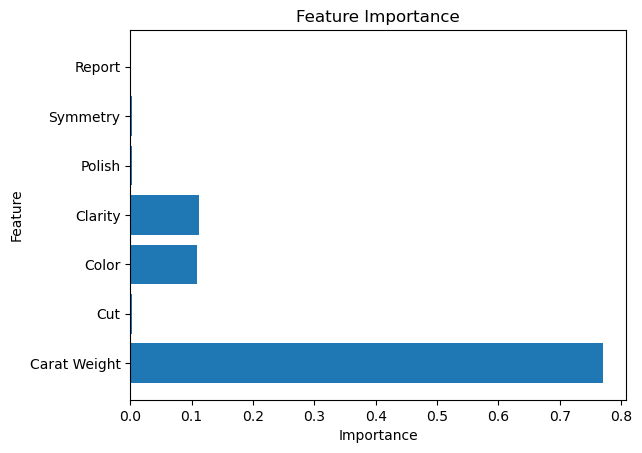

In [9]:
# Step 10: Feature Importance Visualization
# График важности признаков
feature_importances = best_model.feature_importances_
plt.barh(X_train.columns, feature_importances)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

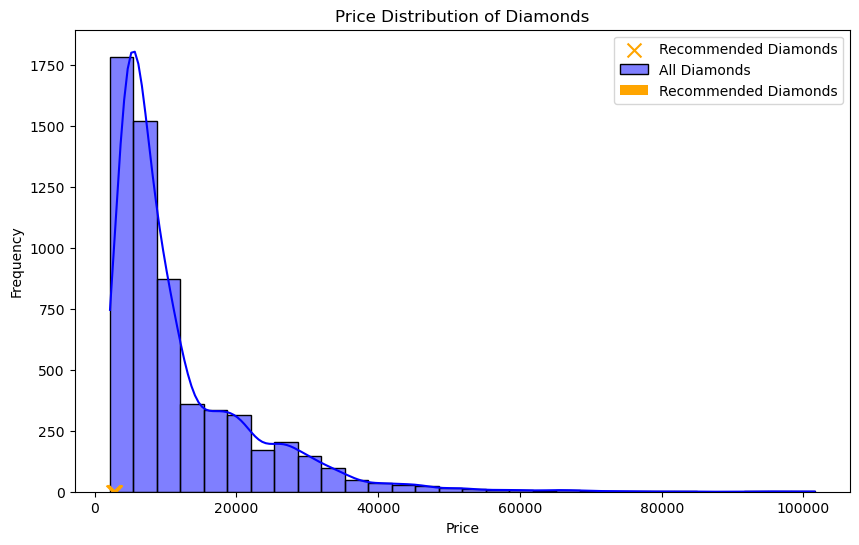

In [10]:
# Step 11: Price Distribution Visualization
# Визуализация распределения цен
plt.figure(figsize=(10, 6))
sns.histplot(raw_data['Price'], bins=30, kde=True, color='blue', alpha=0.5, label='All Diamonds')
sns.histplot(top_5_diamonds['Price'], bins=30, kde=True, color='orange', alpha=1.0, label='Recommended Diamonds')
plt.scatter(top_5_diamonds['Price'], [0] * len(top_5_diamonds), 
            color='orange', label='Recommended Diamonds', marker='x', s=100)
plt.legend()
plt.title('Price Distribution of Diamonds')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Step 12: Save full report to Excel
with pd.ExcelWriter('data/diamond_analysis_report.xlsx') as writer:
    # Сохранение полного набора данных
    raw_data.to_excel(writer, sheet_name='Full Data', index=False)

    # Сохранение фильтрованных данных с минимальным бюджетом
    filtered_data_min_budget.to_excel(writer, sheet_name='Filtered (Min $3000)', index=False)
    
    # Сохранение топ-5 рекомендаций с минимальным бюджетом
    top_5_diamonds.to_excel(writer, sheet_name='Top 5 (Min $3000)', index=False)
    
    # Сохранение фильтрованных данных без минимального бюджета
    filtered_data_no_min_budget.to_excel(writer, sheet_name='Filtered (No Min Budget)', index=False)
    
    # Сохранение топ-5 рекомендаций без минимального бюджета
    top_5_no_min_budget = filtered_data_no_min_budget.sort_values(by='Price per Carat', ascending=True).head(5)
    top_5_no_min_budget.to_excel(writer, sheet_name='Top 5 (No Min Budget)', index=False)

print("Report successfully saved to 'diamond_analysis_report.xlsx'")

Report successfully saved to 'diamond_analysis_report.xlsx'


In [12]:
print("Top 5 Recommended Diamonds:")
pd.set_option('display.width', 1000) 
pd.set_option('display.max_columns', None)
print(top_5_diamonds)

Top 5 Recommended Diamonds:
        ID  Carat Weight  Cut  Color  Clarity  Polish  Symmetry  Report  Price  Predicted Price  Price per Carat
4313  4314          0.80    1      3        2       3         1       1   2662      2772.566540      3465.708175
3858  3859          0.80    1      3        2       3         1       1   2810      2772.566540      3465.708175
904    905          0.85    1      3        2       3         3       1   2905      2959.059365      3481.246312
2590  2591          0.85    1      3        2       3         3       1   2945      2959.059365      3481.246312
3635  3636          0.84    1      3        2       3         1       1   2872      2926.206667      3483.579365


### Final Report Summary

**Objective:**
To help Greg choose the best diamond for an engagement ring that fits within his $3000 budget and matches his preferences for key diamond features.

**Key Results:**

**Model Performance:**
- Mean Absolute Error (MAE): 666.18
- ² Score: 98.5%

The model achieved high accuracy in predicting diamond prices, enabling confident recommendations with an optimal price-to-quality ratio.

**Best Model Parameters:**
- n_estimators: 150
- max_depth: 20
- min_samples_split: 2

**Top-5 Diamond Recommendations** 
Recommendations were based on the lowest price-per-carat ratio among diamonds that met both the budget and feature preferences.
All diamonds in the top-5 list satisfy the following conditions:
- Price ≤ $3000
- Carat weight ≤ 1.0
- Cut quality: "Very Good" or "Ideal"

**Feature Importance:**
- Carat Weight: the most influential factor in determining a diamond's price.
- Clarity and Color also impact pricing but to a lesser degree.

**Price Distribution:**
A distribution plot was created comparing all diamonds to the recommended ones. The plot shows that the selected recommendations are near the upper boundary of the client's budget.

All results and recommendations were saved to an Excel report with the following sheets:
- Full Data: Complete dataset with predictions
- Filtered (Min $3000): Diamonds under $3000
- Top 5 (Min $3000): Top 5 budget-friendly diamonds
- Filtered (No Min Budget): Full data without budget filtering
- Top 5 (No Min Budget): Best diamonds by value without budget filter

Final recommendations were also exported as a CSV file: top_5_diamonds.csv.

